# Example: Dimension reduction of spatial data cubes using YAXArrays.jl

Often, one is interested in summarizing values of a given area of interest.
Areal data usually comes in a raster based format in which values are assigned for a rectangular interval in a lat/lon grid.
This tutorial describes how to create a data cube in which these values are aggegrated for given regions defined bybounding boxes.
The resulting data cube has only one spatial dimenion, i.e., the region and is often called vector data cube.
This concept is also implemented elsewhere, e.g., in [r-spatial](https://r-spatial.org/r/2022/09/12/vdc.html).
There is also a [comparison](https://edzer.github.io/jena/#1) with traditional raster data cubes.

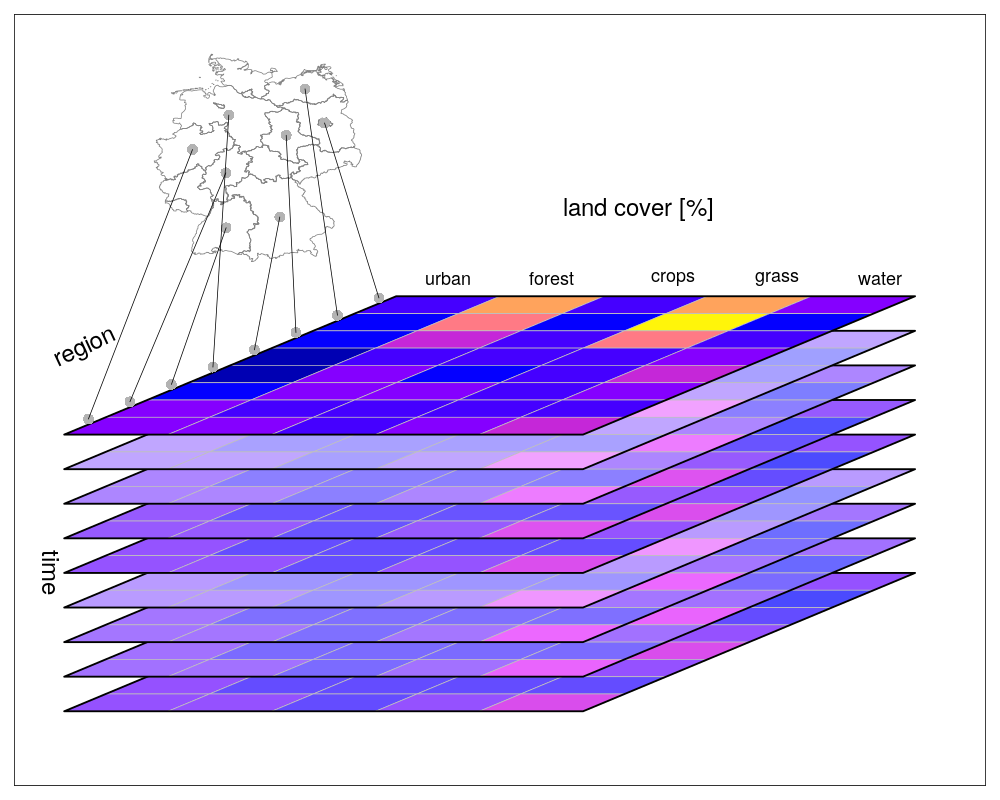

Let's create a raster data cube with some values:

In [1]:
using YAXArrays
using DimensionalData

lon_range = -180:180
lat_range = -90:90
axlist = (
    Dim{:lon}(lon_range),
    Dim{:lat}(lat_range)
)
data = [exp(cosd(lon)) + 3(lat / 90) for lon in lon_range, lat in lat_range]
raster_cube = YAXArray(axlist, data)

361×181 YAXArray{Float64,2} with dimensions: 
  Dim{:lon} Sampled{Int64} -180:180 ForwardOrdered Regular Points,
  Dim{:lat} Sampled{Int64} -90:90 ForwardOrdered Regular Points
Total size: 510.48 KB


The data looks like this:

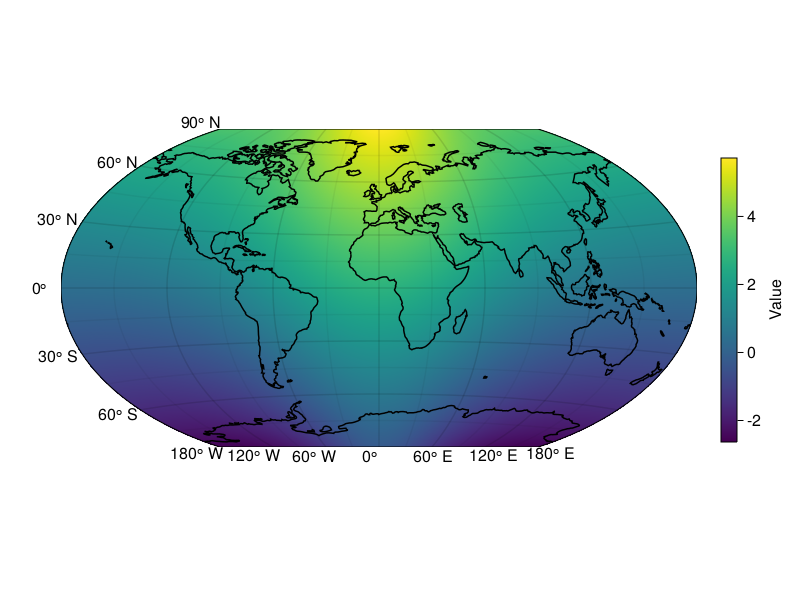

## Toy example demonstrating the Map-Reduce approach

The procedure follows the map-reduce pattern:

1. Map: Function `get_region` returns the vector region for every point of the raster cube
2. Reduce: Apply an aggragation function, e.g., `mean` to have just one value for every region

In YAXArrays, the function `mapCube` applies the reduce step for every region in the function `transform_cube` :

In [2]:
using Statistics

function get_region(lon, lat)
    -25 <= lon < 35 && 30 <= lat < 70 && return "Europe"
    -180 <= lon < -30 && -60 <= lat < 80 && return "Americas"
    return "Other"
end

regions = ["Europe", "Americas", "Other"]
points_to_regions_matrix = [get_region(t...) for t = Iterators.product(raster_cube.lon, raster_cube.lat)]

region_to_indexlist = map(enumerate(regions)) do (i, region)
    findall(isequal(region), points_to_regions_matrix)
end

function transform_cube(xout, xin, regions, region_to_indexlist, agg_func::Function)
    for i in 1:length(regions)
        xout[i] = agg_func(view(xin, region_to_indexlist[i]))
    end
end

vector_cube = mapCube(
    transform_cube,
    raster_cube,
    regions,
    region_to_indexlist,
    mean,
    indims=InDims(:lon, :lat),
    outdims=OutDims(Dim{:region}(regions))
)

3-element YAXArray{Union{Missing, Float64},1} with dimensions: 
  Dim{:region} Categorical{String} String["Europe", "Americas", "Other"] Unordered
Total size: 24.0 bytes


Indeed, the value is much higher in Europe compared to Americas:

In [3]:
vector_cube[At("Europe")]

4.2435960122178225

In [4]:
vector_cube[At("Americas")]

1.3091471815301223

## Create a country vector cube

The example above was a toy example just to demonstrate the map-reduce concept.
Bounding boxes are spatial intervals that could be also implemented with much less overhead, e.g., using `view`.
Let's continue with a real world scenario using more complex polygons as boundaries.

The matrix `points_to_regions_matrix` just contained region labels on the same grid as the `raster_cube`:

In [5]:
points_to_regions_matrix[170:180, 150:180]

11×31 Matrix{String}:
 "Europe"  "Europe"  "Europe"  …  "Other"  "Other"  "Other"  "Other"
 "Europe"  "Europe"  "Europe"     "Other"  "Other"  "Other"  "Other"
 "Europe"  "Europe"  "Europe"     "Other"  "Other"  "Other"  "Other"
 "Europe"  "Europe"  "Europe"     "Other"  "Other"  "Other"  "Other"
 "Europe"  "Europe"  "Europe"     "Other"  "Other"  "Other"  "Other"
 "Europe"  "Europe"  "Europe"  …  "Other"  "Other"  "Other"  "Other"
 "Europe"  "Europe"  "Europe"     "Other"  "Other"  "Other"  "Other"
 "Europe"  "Europe"  "Europe"     "Other"  "Other"  "Other"  "Other"
 "Europe"  "Europe"  "Europe"     "Other"  "Other"  "Other"  "Other"
 "Europe"  "Europe"  "Europe"     "Other"  "Other"  "Other"  "Other"
 "Europe"  "Europe"  "Europe"  …  "Other"  "Other"  "Other"  "Other"

We can just rasterize the country boundary polygons to archive the same result:

In [6]:
using Rasters, RasterDataSources, ArchGDAL, Shapefile, Downloads, Extents

# Download a borders shapefile
shapefile_url = "https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/rasterize_country.shp"
shapefile_name = "country_borders.shp"
isfile(shapefile_name) || Downloads.download(shapefile_url, shapefile_name)

function rasterize_country(shapefile_name::String, country_id::Integer)
    rasterize(
        last, # reducer function
        Shapefile.Handle(shapefile_name).shapes[country_id];
        to=Extent(X=(lon_range.start, lon_range.stop), Y=(lat_range.start, lat_range.stop)),
        size=size(raster_cube.data), missingval=0, fill=country_id, boundary=:touches, progress=false
    )
end

italy_raster = rasterize_country(shapefile_name, 91)

361×181 Raster{Int64,2} last with dimensions: 
  X Projected{Float64} -180.0:0.997229916897507:179.0027700831025 ForwardOrdered Regular Intervals,
  Y Projected{Float64} -90.0:0.994475138121547:89.00552486187846 ForwardOrdered Regular Intervals
extent: Extent(X = (-180.0, 180.0), Y = (-90.0, 90.0))missingval: 0parent:
           -90.0  -89.0055  -88.011  …  86.0221  87.0166  88.011  89.0055
 -180.0      0      0         0          0        0        0       0
 -179.003    0      0         0          0        0        0       0
 -178.006    0      0         0          0        0        0       0
 -177.008    0      0         0          0        0        0       0
 -176.011    0      0         0      …   0        0        0       0
 -175.014    0      0         0          0        0        0       0
 -174.017    0      0         0          0        0        0       0
 -173.019    0      0         0          0        0        0       0
    ⋮                                ⋱                

Now we can use this raster matrix to create `vector_cube` using more complex country boundaries:

In [7]:
points_to_regions_matrix = italy_raster.data
regions = [0,91]

region_to_indexlist = map(enumerate(regions)) do (i, region)
    findall(isequal(region), points_to_regions_matrix)
end

function transform_cube(xout, xin, regions, region_to_indexlist, agg_func::Function)
    for i in 1:length(regions)
        xout[i] = agg_func(view(xin, region_to_indexlist[i]))
    end
end

vector_cube = mapCube(
    transform_cube,
    raster_cube,
    regions,
    region_to_indexlist,
    mean,
    indims=InDims(:lon, :lat),
    outdims=OutDims(Dim{:region}([:Elsewhere, :ITA,]))
)
vector_cube

2-element YAXArray{Union{Missing, Float64},1} with dimensions: 
  Dim{:region} Categorical{Symbol} Symbol[:Elsewhere, :ITA] ForwardOrdered
Total size: 16.0 bytes


In [8]:
vector_cube[At(:ITA)]

4.062727561445587

In [9]:
vector_cube.data

2-element Vector{Union{Missing, Float64}}:
 1.2603612019438004
 4.062727561445587

This gives the mean values for Italy and elsewhere.
To include other countries, one need to run the  function `rasterize_country` multiple times and combine the resulting matricies.
Due to the rasterization, some tiles might be assigned to multiple countries.
We'll take the country with the highest id.

In [10]:
# Data from https://github.com/nvkelso/natural-earth-vector
countries  = [:IDN, :MYS, :CHL, :ITA, :DEU]
countries_int = [1,2,3,91,50]

country_rasters = rasterize_country.(shapefile_name, countries_int)
country_raster = reduce((x,y) -> max.(x,y), country_rasters)

361×181 Raster{Int64,2} with dimensions: 
  X Projected{Float64} -180.0:0.997229916897507:179.0027700831025 ForwardOrdered Regular Intervals,
  Y Projected{Float64} -90.0:0.994475138121547:89.00552486187846 ForwardOrdered Regular Intervals
extent: Extent(X = (-180.0, 180.0), Y = (-90.0, 90.0))missingval: 0parent:
           -90.0  -89.0055  -88.011  …  86.0221  87.0166  88.011  89.0055
 -180.0      0      0         0          0        0        0       0
 -179.003    0      0         0          0        0        0       0
 -178.006    0      0         0          0        0        0       0
 -177.008    0      0         0          0        0        0       0
 -176.011    0      0         0      …   0        0        0       0
 -175.014    0      0         0          0        0        0       0
 -174.017    0      0         0          0        0        0       0
 -173.019    0      0         0          0        0        0       0
    ⋮                                ⋱                     

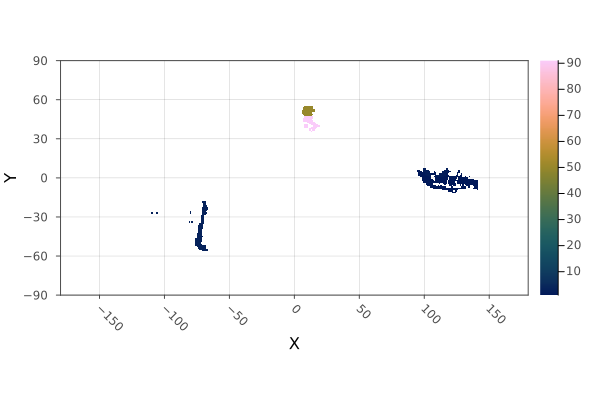

In [11]:
using Plots
plot(country_raster; max_res=3000)

In [12]:
points_to_regions_matrix = country_raster.data

region_to_indexlist = map(enumerate(countries_int)) do (i, countries_int)
    findall(isequal(countries_int), points_to_regions_matrix)
end

function transform_cube(xout, xin, regions, region_to_indexlist, agg_func::Function)
    for i in 1:length(regions)
        xout[i] = agg_func(view(xin, region_to_indexlist[i]))
    end
end

vector_cube2 = mapCube(
    transform_cube,
    raster_cube,
    countries_int,
    region_to_indexlist,
    mean,
    indims=InDims(:lon, :lat),
    outdims=OutDims(Dim{:country}(vcat(countries, [:Elsewhere])))
)

6-element YAXArray{Union{Missing, Float64},1} with dimensions: 
  Dim{:country} Categorical{Symbol} Symbol[IDN, MYS, …, DEU, Elsewhere] Unordered
Total size: 48.0 bytes


In [13]:
zip(vcat(countries, [:Elsewhere]), vector_cube2.data) |> collect

6-element Vector{Tuple{Symbol, Union{Missing, Float64}}}:
 (:IDN, 0.5387384802994952)
 (:MYS, 0.8421117400895043)
 (:CHL, 0.05622781396234247)
 (:ITA, 4.062727561445587)
 (:DEU, 4.3899435294154046)
 (:Elsewhere, missing)

## Application: Discrete global grid systems

<img src="https://github.com/danlooo/DGGS.jl/raw/main/docs/src/assets/logo.drawio.svg" width = "30%" align = "right"/>

This concept is used in the Julia package DGGS.jl: Hereby, the two spatial dimensions are reduced to one cell id representing a regular polygon of equal area at specific location on the earth.


DGGS.jl is a Julia Package for scalable geospatial analysis using Discrete Global Grid Systems (DGGS), which tessellate the surface of the earth with hierarchical cells of equal area, minimizing distortion and loading time of large geospatial datasets, which is crucial in spatial statistics and building Machine Learning models.
https://github.com/danlooo/DGGS.jl